# Image Classification

Before diving into object detection, it's useful to understand **image classification**, one of the most fundamental tasks in computer vision.

**Image classification** involves assigning a single label to an entire image. For example, given an image, a classification model might predict whether it contains a **cat**, **dog**, or **car**.

This task is typically performed using **Convolutional Neural Networks (CNNs)**, which can learn to recognize patterns such as edges, textures, and shapes. These features help the model understand what kind of object is present in the image.

<p align="center">
  <img src="https://goodboychan.github.io/images/copied_from_nb/image/cnn_result.png" width="900"/>
</p>

In the image above, a classifier might correctly label the first image as **cat** and the second as **dog**.

However, what if both a cat and a dog appear in the same image? Or what if we need to know **where** in the image these objects are?


## Why Image Classification Is Not Enough

While classification tells us **what** is in an image, it does **not** tell us **where** the object is located.

Consider the example below:

<p align="center">
  <img src="https://imerit.net/wp-content/uploads/2023/04/Feature_Real-Time-Object-Detection-Using-YOLO.jpg" width="700"/>
</p>

In this image, there are multiple objects (people, cars, traffic lights). An image classification model can only predict one label — for example, "person" — and cannot provide information about **how many people** there are or **where** they appear in the image.

This is where **object detection** comes in.

Object detection extends classification by not only identifying the objects in an image but also **localizing** them using **bounding boxes**.

In the next section, we will explore **YOLO (You Only Look Once)**, a popular and powerful real-time object detection model.

---

# Introduction to YOLO for Object Detection

In this notebook, we will use **YOLO (You Only Look Once)**, a state-of-the-art object detection model. YOLO is widely recognized for its balance of speed and accuracy, making it one of the most effective models for real-time object detection.

YOLO performs object detection by predicting bounding boxes and class probabilities directly from full images in a single forward pass of the neural network, hence the name **"You Only Look Once."**

Object detection enables us to not only identify objects in an image but also localize their positions.


## How Are Images Annotated for Object Detection?

To train an object detection model, we need more than just image-level labels — we need to know **where** each object is in the image and **what** it is.

This is done through a process called **annotation**.

### What Is an Annotation?

An annotation for object detection typically includes:

- A **bounding box**: A rectangle that encloses the object.
- A **class label**: The name or ID of the object inside the bounding box.

For example, in an image with two people and one car, the annotations might look like this:

image1.jpg

1 0.45 0.60 0.30 0.50 # person

1 0.20 0.30 0.25 0.40 # person

2 0.75 0.65 0.30 0.20 # car


Each line represents one object and contains:

[class_id] [x_center] [y_center] [width] [height]


All coordinates are **normalized** (i.e., values between 0 and 1), relative to the image dimensions.

This is the format used in **YOLO**. For other models, the format might differ slightly for example, [xmin,ymin,xmax,ymax] or [xmin,ymin,width,height] ,etc.

### Visualization

Here is what annotated bounding boxes look like on an image:

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:900/1*EYtn2YE7b6MTzMQyD2R3nA.jpeg" width="900"/>
</p>

Each box corresponds to a detected object, along with its class label.

Now, Lets try annotating a few images of our own!

---


# Setting up the Environment


We will work with the [Ultralytics YOLOv8](https://docs.ultralytics.com/) implementation, which offers a clean and user-friendly API for training, validation, and inference.


In [6]:
# lets install the ultralytics library
!pip install ultralytics

## Importing Libraries

# Download Dataset
We will mount the drive so that we can use the dataset for training purposes. You can find the dataset we will use [here](https://drive.google.com/drive/folders/1Ct6wnPraUDzci712OircgriMQ6KDEGBz?usp=sharing).

You had requested to download the dataset and upload it to your Google Drive. Please follow these steps:
* Download the dataset using the link above.
* Unzip the downloaded file.
* Locate the folder named Tomato Counting.v1-tomato.yolov8 inside the unzipped contents. Sometimes the unzip tool may nest it inside an extra directory, so make sure to extract the correct folder.
* Upload the Tomato Counting.v1-tomato.yolov8 folder directly to your Google Drive.


# Annotating Images of Our Own

For annotating images, we will use an online tool offered by [Roboflow](https://roboflow.com/). Roboflow provides an easy-to-use interface for labeling objects in images and exporting the annotations in formats compatible with popular object detection models like YOLO.

### Steps to Annotate Using Roboflow:

1. **Create a Free Account**  
   Go to [roboflow.com](https://roboflow.com/) and sign up for a free account.

2. **Start a New Project**  
   After logging in, click on **"Create New Project"**.  
   - Give your project a name  
   - Choose the project type as **Object Detection**  
   - Set the object classes (e.g., person, dog, bottle)

3. **Upload Your Images**  
   Upload the images you want to annotate. You can drag and drop a folder or select individual files.

4. **Label the Objects**  
   Use the bounding box tool to draw rectangles around each object of interest in the images. Assign the appropriate class label to each box.

5. **Generate the Dataset**  
   Once labeling is complete, click on **"Generate"** to process your dataset. You can choose how to split the dataset (train/valid/test).

6. **Export in YOLO Format**  
   Finally, click on **"Download Dataset"** and choose the export format as **YOLOv8**. This will give you:
   - A folder of images
   - A folder of `.txt` annotation files (one per image)
   - A `data.yaml` file describing the dataset

You can now use this annotated dataset directly to train your YOLO model.

In the next section, we’ll see how to load this dataset and begin training.

---


In [7]:
!pip install ultralytics

In [8]:
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from google.colab import drive
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os

In [10]:
drive.mount('/content/drive')

Mounted at /content/drive


## Setting up the Dataset




In [11]:
dataset_path = "/content/drive/MyDrive/Tomato Counting.v1-tomato.yolov8"

dataset_yaml_path = os.path.join(dataset_path, "data.yaml")

test_folder_path = os.path.join(dataset_path, "test")
test_images = np.sort(os.listdir(os.path.join(test_folder_path, "images")))

In [12]:
def show_image(test_folder_path):
    test_images = os.listdir(os.path.join(test_folder_path, "images"))
    random_idx = np.random.randint(0, len(test_images))
    image = test_images[random_idx]

    image_path = os.path.join(test_folder_path, "images", image)
    label_path = os.path.join(test_folder_path, "labels", image.replace(".jpg", ".txt"))

    # Load image
    img = Image.open(image_path).convert('RGB')
    img_width, img_height = img.size

    # Read label
    label = pd.read_csv(label_path, sep=" ", header=None)
    label.columns = ["class", "x_center", "y_center", "width", "height"]

    # Draw bounding boxes
    draw = ImageDraw.Draw(img)
    for i in range(len(label)):
        x_center, y_center, width, height = label.iloc[i, 1:]

        # Convert normalized coordinates to absolute pixel values
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=2)

    return img


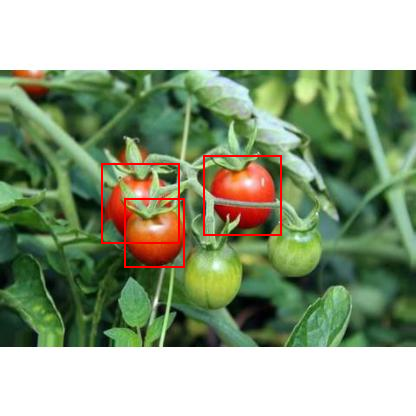

In [13]:
show_image(test_folder_path)

Before training with YOLO, it's important to organize your dataset in a format that Ultralytics expects. The folder structure should look like this:

```
dataset/
├── test/
│ ├── images/
│ │ ├── img1.jpg
│ │ ├── img2.jpg
│ │ └── ...
│ └── labels/
│ ├── img1.txt
│ ├── img2.txt
│ └── ...
├── train/
│ ├── images/
│ │ ├── img1.jpg
│ │ ├── img2.jpg
│ │ └── ...
│ └── labels/
│ ├── img1.txt
│ ├── img2.txt
│ └── ...
```


### Important Guidelines:
- Every image must have a corresponding `.txt` file in the `labels` directory with the **same name** (e.g., `img1.jpg` ↔ `img1.txt`).
- Annotation files should follow the YOLO format:  ```<class_id> <x_center> <y_center> <width> <height>```
- All values should be **normalized** between 0 and 1 relative to the image width and height.
- The `train` and `val` folders should be clearly separated. You can also include a `test` folder if you wish to evaluate the model on unseen data.
- Avoid corrupt or mismatched files. Every image in the `images` folder must have a label file, and vice versa.

With this structure in place, you’ll be able to train YOLO models using Ultralytics with minimal friction.

## Loading a YOLO Model

We will now be using the YOLOv8 model for object detection. You might wonder, why 'v8'? Yes, there are multiple versions of YOLO models available, with over a dozen released so far. Each version comes with improvements in accuracy, speed, or specific use cases.

To learn more about the different YOLO versions and their capabilities, you can visit the [Ultralytics documentation](https://docs.ultralytics.com/models/).


In [14]:
yolo_model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 106MB/s]


In [15]:
yolo_model.train(data=dataset_yaml_path, epochs=50,device="cuda",batch=32,val=False, augment=True,verbose=False)
print("Model training Complete")

Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tomato Counting.v1-tomato.yolov8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

100%|██████████| 755k/755k [00:00<00:00, 19.1MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 103MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.2 ms, read: 2.6±5.7 MB/s, size: 23.4 KB)


train: Scanning /content/drive/MyDrive/Tomato Counting.v1-tomato.yolov8/train/labels... 65 images, 40 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:34<00:00,  3.07it/s]

train: New cache created: /content/drive/MyDrive/Tomato Counting.v1-tomato.yolov8/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 0.1±0.0 MB/s, size: 22.1 KB)


val: Scanning /content/drive/MyDrive/Tomato Counting.v1-tomato.yolov8/test/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.92G      1.739        3.2      1.841         40        640: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/50      3.94G      1.741      3.146      1.791         67        640: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.96G      1.492      2.427      1.488         49        640: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.96G      1.453      1.882      1.426         51        640: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.97G      1.372      1.696      1.368         46        640: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.97G      1.422      1.805      1.413         39        640: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.97G      1.407      1.604      1.322         50        640: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.97G      1.317      1.534      1.267         31        640: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.97G       1.41      1.511      1.356         47        640: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.99G      1.327      1.393      1.324         58        640: 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.99G      1.341      1.402      1.297         73        640: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.01G      1.326      1.385      1.323         37        640: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.01G      1.434      1.399      1.336         76        640: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.01G      1.296      1.332      1.318         53        640: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.01G      1.275      1.312      1.283         80        640: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.01G      1.357      1.323      1.327         37        640: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.01G      1.257      1.312      1.255         66        640: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.01G      1.347      1.276      1.318        105        640: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.01G      1.279      1.246      1.299         50        640: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.02G      1.287      1.225      1.289         45        640: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.02G      1.347      1.227      1.272         70        640: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.02G      1.308      1.269      1.312         34        640: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.02G      1.277      1.149      1.269         36        640: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.03G      1.292      1.272      1.269         63        640: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.03G      1.327      1.298       1.33         84        640: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.03G      1.358      1.252      1.312         46        640: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.05G       1.29      1.177      1.258         87        640: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.05G      1.201      1.187      1.232         47        640: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.05G      1.215      1.137      1.261         44        640: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.05G      1.161      1.142      1.222         41        640: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.07G      1.204      1.093      1.228         70        640: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.07G      1.228      1.135      1.256         55        640: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.07G      1.119      1.089      1.226         48        640: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.07G      1.167      1.078      1.208         65        640: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.08G      1.237      1.072      1.249         76        640: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.08G      1.159      1.078      1.219         40        640: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.08G      1.099       1.08      1.172         57        640: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.08G      1.073      1.024      1.169         63        640: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.08G      1.076       1.01      1.201         55        640: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.08G      1.148      1.036      1.217         49        640: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.08G      1.113      1.012      1.176         44        640: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.08G      1.032     0.9989      1.146         24        640: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.08G      1.056     0.9392      1.139         27        640: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.08G      1.042      1.003      1.157         36        640: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.08G       1.05      1.039      1.134         76        640: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.08G     0.9677     0.9115      1.122         34        640: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.08G      1.127      1.105      1.182         18        640: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.08G      1.027      0.898      1.157         35        640: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.08G     0.9657     0.8618      1.093         43        640: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.08G     0.9458     0.9549        1.1         19        640: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


                   all         45        236      0.947      0.913      0.942      0.576

50 epochs completed in 0.029 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


                   all         45        236      0.923      0.924      0.949      0.589
Speed: 0.2ms preprocess, 7.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train
Model training Complete


In [16]:
results = yolo_model.val(data=dataset_yaml_path,verbose=False)

Ultralytics 8.3.147 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 10.9±2.8 MB/s, size: 23.0 KB)


val: Scanning /content/drive/MyDrive/Tomato Counting.v1-tomato.yolov8/test/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


                   all         45        236      0.923      0.924      0.949      0.589
Speed: 10.2ms preprocess, 25.4ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/detect/train2


In [17]:
for metrics, val in results.results_dict.items():
  print(f"{metrics}: {val:.3f}")

metrics/precision(B): 0.923
metrics/recall(B): 0.924
metrics/mAP50(B): 0.949
metrics/mAP50-95(B): 0.589
fitness: 0.625


In [18]:
results.to_df()

,class_name,box-p,box-r,box-f1,box-map,box-map50,box-map75
0,tomato,0.92268,0.923729,0.923204,0.589189,0.949138,0.664666


In [19]:
def show_image_with_prediction(test_folder_path,yolo_model):
    test_images = os.listdir(os.path.join(test_folder_path, "images"))
    random_idx = np.random.randint(0, len(test_images))
    image = test_images[random_idx]

    image_path = os.path.join(test_folder_path, "images", image)
    label_path = os.path.join(test_folder_path, "labels", image.replace(".jpg", ".txt"))

    # Load image
    img = Image.open(image_path).convert('RGB')
    img_width, img_height = img.size

    # Read label
    label = pd.read_csv(label_path, sep=" ", header=None)
    label.columns = ["class", "x_center", "y_center", "width", "height"]

    predicted = yolo_model(img)[0]
    predicted = predicted.boxes.data.cpu().numpy()
    draw = ImageDraw.Draw(img)

    # Draw bounding boxes
    for x_min, y_min, x_max, y_max, confidence, class_id in predicted:
        x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="yellow", width=2)

    for i in range(len(label)):
        x_center, y_center, width, height = label.iloc[i, 1:]

        # Convert normalized coordinates to absolute pixel values
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=2)

    return img

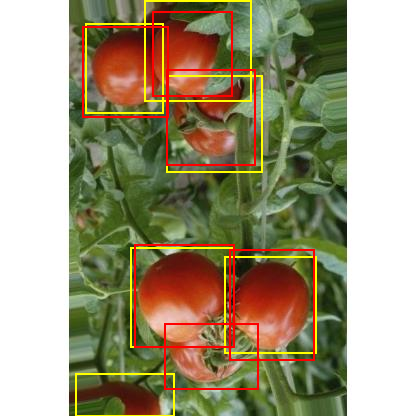

In [20]:
show_image_with_prediction(test_folder_path,yolo_model)